# Ensembling
This notebook aims to help gain a better understanding of ensembling by training four different models where each model is trained on a different subset of the entire dataset. Afterwards, the mean and the median of the output of each of the four differemt models is computed and used to fit the neural network model to the true function

### Imports
Import the libraries needed to define and train a neural network model as well as plot the output of the neural network model

In [11]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

### Define True Function
Define the true function, which will be the function that the neural network model will be trying to model

In [12]:
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

### Define Function to Generate Points with Noise
Define a function that takes the input values and computes the output using the true function. After computing the output, the function then adds variance to the output values to model noise.

In [13]:
def generate_data(n_data, sigma_y=0.3):
    # Generate x values from [0, 1]
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)

    # Evaluate the output value using the true function
    # Add noise to the output values
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y, 1)
    return x,y

### Define Plotting Function
Define a function that plots the true function and the neural network model, as well as the variance in the data points

In [14]:
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, x')
    ax.set_ylabel('Output, y')
    plt.show()

### Compute True Function
Compute the output of the true function using the defined input values (x_func)

In [15]:
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func)

### Compute Data Points
Compute the data points of the true function and add variance to the data points

In [16]:
np.random.seed(1)
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

/var/folders/hd/f_gk36z51lj__phqtmgrmv8w0000gn/T/ipykernel_96077/2043700207.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
/var/folders/hd/f_gk36z51lj__phqtmgrmv8w0000gn/T/ipykernel_96077/2043700207.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


### Plot True Function and Data Points
Plot the true function and the data points (orange dot) as well as the variance of the data points

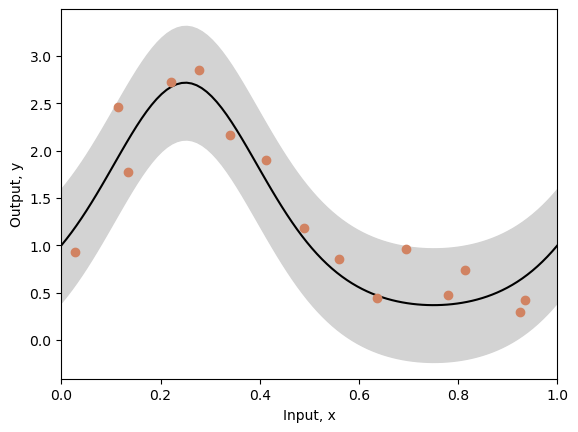

In [17]:
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

### Define Neural Network Model

In [18]:
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines 
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Compute weighted activations and sum to get the output
        y = y + omega[c_hidden] * h
    # Add bias, beta (parameters)
    y = y + beta

    return y

### Define Training Function
Define a function that fits the parameters of the neural network model to minimize the loss function

In [19]:
def fit_model_closed_form(x,y,n_hidden):
  n_data = len(x)
  A = np.ones((n_data, n_hidden+1))
  for i in range(n_data):
      for j in range(1,n_hidden+1):
          # Compute Preactivation
          A[i,j] = x[i]-(j-1)/n_hidden
          # Apply the ReLU function
          if A[i,j] < 0:
              A[i,j] = 0

  # Add a regularization term to the loss function
  reg_value = 0.00001
  regMat = reg_value * np.identity(n_hidden+1)
  regMat[0,0] = 0

  ATA = np.matmul(np.transpose(A), A) +regMat
  ATAInv = np.linalg.inv(ATA)
  ATAInvAT = np.matmul(ATAInv, np.transpose(A))
  beta_omega = np.matmul(ATAInvAT,y)
  beta = beta_omega[0]
  omega = beta_omega[1:]

  return beta, omega

### Compute Best Parameters
Compute the parameters that results in the minimization of the loss function

In [20]:
beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=14)

### Compute Neural Network Model
Using the best parameters, compute the output of the neural network model

In [21]:
x_model = np.linspace(0,1,100)
y_model = network(x_model, beta, omega)

### Plot True Function and Neural Network Model

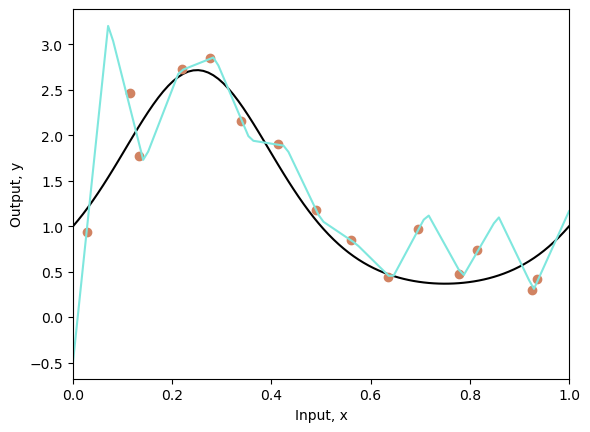

In [22]:
plot_function(x_func, y_func, x_data,y_data, x_model, y_model)

### Compute Mean Squarred Error
Compute the mean squarred error between the true function (black) and the neural network model (cyan)

In [23]:
mean_sq_error = np.mean((y_model-y_func) * (y_model-y_func))
print(f"Mean square error = {mean_sq_error:3.3f}")

Mean square error = 0.195


## Ensembling

### Define the Number of Models

In [24]:
n_model = 4

### Define Array Structure
Define an array to store the output prediction values from all the neural network models

In [25]:
all_y_model = np.zeros((n_model, len(y_model)))

### Train Each Model
Train each model, where each model is trained by using the resampled data (subset of the main dataset).

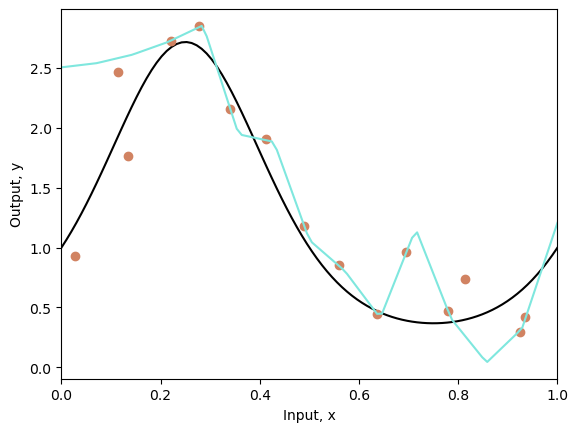

Mean square error = 0.222


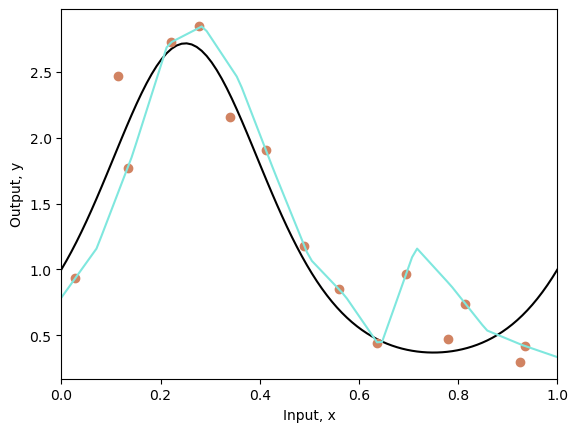

Mean square error = 0.098


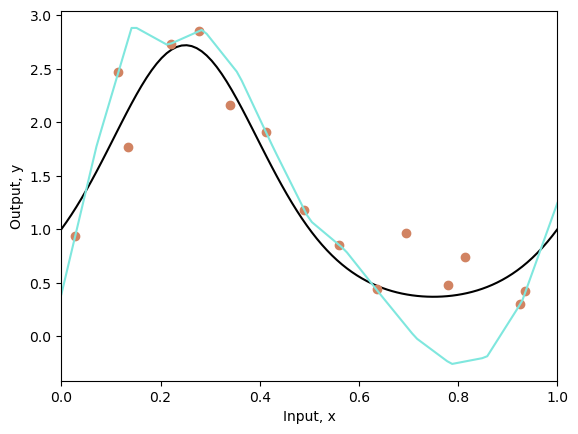

Mean square error = 0.120


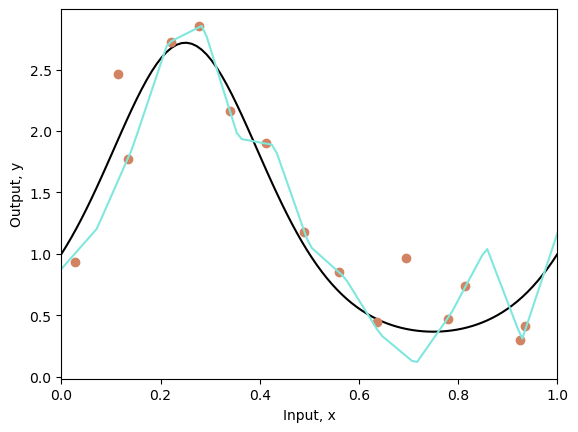

Mean square error = 0.048


In [26]:
for c_model in range(n_model):
    # Resample data to create a subset of the main dataset for the model
    resampled_indices = np.random.choice(np.arange(0,n_data,1), size=n_data)

    # Extract the resampled x and y data
    x_data_resampled = x_data[resampled_indices]
    y_data_resampled = y_data[resampled_indices]

    # Train the model
    beta, omega = fit_model_closed_form(x_data_resampled,y_data_resampled,n_hidden=14)

    # Compute the model
    y_model_resampled = network(x_model, beta, omega)

    # Store the output
    all_y_model[c_model,:] = y_model_resampled

    # Plot the true function and the model
    plot_function(x_func, y_func, x_data,y_data, x_model, y_model_resampled)

    # Compute the mean squared error between the fitted model (cyan) and the true function wh(black)
    mean_sq_error = np.mean((y_model_resampled-y_func) * (y_model_resampled-y_func))
    print(f"Mean square error = {mean_sq_error:3.3f}")

### Compute Median of All Outputs
Compute the median of the output at each x-value of each trained neural network model

In [27]:
y_model_median = np.median(all_y_model,axis = 0)

### Plot True Function and Median-Fitted Model
Plot the true function as well as the median-fitted model, which is a neural network model that uses the median above to model the true function

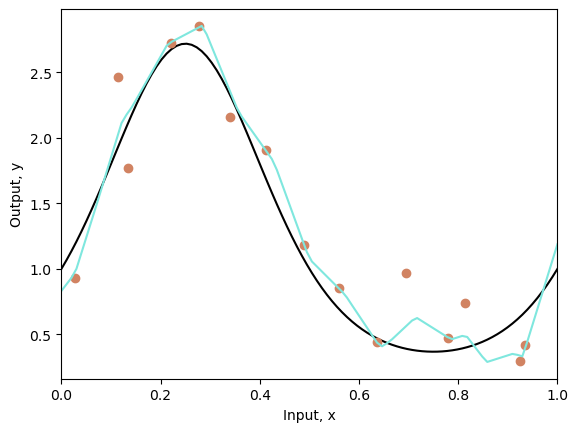

In [28]:
plot_function(x_func, y_func, x_data,y_data, x_model, y_model_median)

### Compute Mean Squarred Error
Compute the mean squarred error between the true function (black) and the neural network model (cyan)

In [29]:
mean_sq_error = np.mean((y_model_median-y_func) * (y_model_median-y_func))
print(f"Mean square error = {mean_sq_error:3.3f}")

Mean square error = 0.020


### Compute Mean of All Outputs
Compute the mean of the output at each x-value of each trained neural network model

In [30]:
y_model_mean = np.mean(all_y_model, axis = 0)

### Plot True Function and Mean-Fitted Model
Plot the true function as well as the mean-fitted model, which is a neural network model that uses the mean above to model the true function

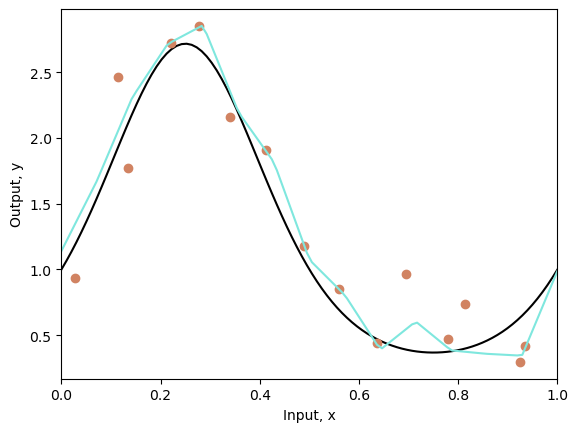

In [31]:
plot_function(x_func, y_func, x_data,y_data, x_model, y_model_mean)

### Compute Mean Squarred Error
Compute the mean squarred error between the true function (black) and the neural network model (cyan)

In [32]:
mean_sq_error = np.mean((y_model_mean-y_func) * (y_model_mean-y_func))
print(f"Mean square error = {mean_sq_error:3.3f}")

Mean square error = 0.018
